In [46]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

df = pd.read_csv("train.csv")

def dfcleaner(dataframe):
    dataframe["Cabin"] = dataframe["Cabin"].fillna("0/999999/0")
    dataframe = dataframe.fillna(0)
    
    dataframe["Cabinnumber"] = dataframe["Cabin"].str.extract("\/(\w*)\/").astype("int32")
    dataframe["Cabindeck"] = dataframe["Cabin"].str.extract("^(\w*)\/")
    dataframe["Cabinside"] = dataframe["Cabin"].str.extract("\/(\w*)$")

    dataframe["Totalbill"] = dataframe["RoomService"] + dataframe["FoodCourt"] + dataframe["ShoppingMall"] + dataframe["Spa"] + dataframe["VRDeck"]

    dataframe["Group"] = dataframe["PassengerId"].str.extract("^(\d{4})")
    filter = dataframe["Group"].value_counts().to_frame().reset_index()
    filter.columns = ["Group", "Freq"]
    filter = filter[filter["Freq"] < 5]
    dataframe.loc[dataframe["Group"].isin(filter["Group"]), "Group"] = 0

    dataframe = pd.get_dummies(dataframe, columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Cabindeck", "Cabinside", "Group"], drop_first = True)
    #dataframe = pd.get_dummies(dataframe, columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Cabindeck", "Cabinside"], drop_first = True)
    
    
    dataframe.loc[dataframe["Cabinnumber"] == 999999, "Cabinnumber"] = 0

    return dataframe

In [47]:
df = dfcleaner(df)

In [48]:
df = df.select_dtypes(exclude = ["object"])

In [49]:
X, y = df.drop(["Transported"], axis = 1).values, df["Transported"].values
y = (y * 1).astype(np.int8)

In [50]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.60, random_state = 42)

X_train.shape, X_val.shape, X_test.shape

((6085, 154), (1043, 154), (1565, 154))

In [51]:
scaler = StandardScaler()
#scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)
scaled_X_test = scaler.transform(X_test)

In [52]:
scaled_X_train = scaled_X_train.reshape(scaled_X_train.shape[0], scaled_X_train.shape[1], 1)
scaled_X_val = scaled_X_val.reshape(scaled_X_val.shape[0], scaled_X_val.shape[1], 1)
scaled_X_test = scaled_X_test.reshape(scaled_X_test.shape[0], scaled_X_test.shape[1], 1)

scaled_X_train.shape

(6085, 154, 1)

In [111]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D

def MLP():
    model = Sequential(name = "MLP")
    model.add(Conv1D(filters = 32, kernel_size = 3, activation='relu', input_shape=(X_train.shape[1], 1), kernel_initializer = "he_normal"))
    model.add(Conv1D(filters = 64, kernel_size = 3, activation='relu', kernel_initializer = "he_normal"))
    #model.add(Conv1D(filters=1, kernel_size=12, strides = 10, activation='relu', input_shape=(X_train.shape[1], 1), kernel_initializer = "he_normal"))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(loss = "binary_crossentropy", optimizer = Adam(learning_rate = 0.0001), metrics = ["acc"])
    return model

model = MLP()
model.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 152, 32)           128       
                                                                 
 conv1d_69 (Conv1D)          (None, 150, 64)           6208      
                                                                 
 flatten_25 (Flatten)        (None, 9600)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              9831424   
                                                                 
 dropout_34 (Dropout)        (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               524800    
                                                                 
 dropout_35 (Dropout)        (None, 512)               0       

In [112]:
model.fit(scaled_X_train, y_train, epochs = 50, validation_data = (scaled_X_val, y_val), verbose = 1)

Epoch 1/50


2022-05-11 01:08:02.151346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - ETA: 0s - loss: 0.6590 - acc: 0.7433

2022-05-11 01:08:05.981562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191/191 [==============================] - 4s 19ms/step - loss: 0.6590 - acc: 0.7433 - val_loss: 0.6176 - val_acc: 0.7584
Epoch 2/50
191/191 [==============================] - 3s 17ms/step - loss: 0.5368 - acc: 0.7804 - val_loss: 0.5764 - val_acc: 0.7546
Epoch 3/50
191/191 [==============================] - 3s 17ms/step - loss: 0.4907 - acc: 0.7877 - val_loss: 0.5499 - val_acc: 0.7737
Epoch 4/50
191/191 [==============================] - 3s 17ms/step - loss: 0.4730 - acc: 0.7934 - val_loss: 0.4919 - val_acc: 0.7737
Epoch 5/50
191/191 [==============================] - 3s 17ms/step - loss: 0.4454 - acc: 0.7995 - val_loss: 0.4920 - val_acc: 0.7785
Epoch 6/50
191/191 [==============================] - 3s 17ms/step - loss: 0.4403 - acc: 0.7987 - val_loss: 0.5137 - val_acc: 0.7756
Epoch 7/50
191/191 [==============================] - 3s 17ms/step - loss: 0.4213 - acc: 0.8066 - val_loss: 0.4768 - val_acc: 0.7766
Epoch 8/50
191/191 [==============================] - 3s 17ms/step - loss: 0.418

In [113]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
y_pred = model.predict(scaled_X_test)
y_pred = (y_pred.ravel() > 0.5) * 1

2022-05-11 09:25:10.396494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.80      0.74      0.77       764
           1       0.77      0.83      0.80       801

    accuracy                           0.79      1565
   macro avg       0.79      0.78      0.78      1565
weighted avg       0.79      0.79      0.78      1565



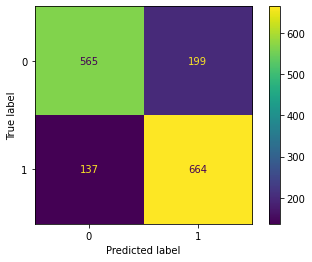

In [114]:
y_pred = ((y_pred > 0.5) * 1).astype(np.int8)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()